In [1]:
# Memory-Efficient Version for Task 2: Variety Classification
import os
import glob
import random
import cv2 as cv
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image, ImageFile

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, Sequential, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Suppress TensorFlow warnings
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
random.seed(45)

# Set Load Truncated Images to True
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Enable memory growth for GPU if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(tf.__version__)

2.19.0


In [3]:
# Setup Configuration and Constants
batch_size = 32  # Reduced batch size
img_height = 256
img_width = 256

# Define paths
HOME_PATH = os.getcwd() + "/"
TRAIN_IMG_PATH = HOME_PATH + 'train_images'
TEST_IMG_PATH = HOME_PATH + 'test_images'
META_TRAIN_PATH = HOME_PATH + 'meta_train.csv'
CHECKPOINT_MODEL_PATH = HOME_PATH + 'paddy_models/best_vit_variety_model.keras'
FINAL_MODEL_PATH = HOME_PATH + 'paddy_models/vit_variety_model.keras'
FINAL_WEIGHTS_PATH = HOME_PATH + 'paddy_models/vit_variety_weights.weights.h5'

In [ ]:
# Create models directory if it doesn't exist
os.makedirs('paddy_models', exist_ok=True)

# Load metadata
print("Loading metadata...")
meta_train = pd.read_csv(META_TRAIN_PATH)

# Check unique varieties
unique_varieties = meta_train['variety'].unique()
num_varieties = len(unique_varieties)
print(f"Number of unique varieties: {num_varieties}")
print(f"Varieties: {unique_varieties}")

# Create variety label encoder
variety_encoder = LabelEncoder()
variety_labels = variety_encoder.fit_transform(meta_train['variety'])
variety_to_idx = {variety: idx for idx, variety in enumerate(variety_encoder.classes_)}

# Save label encoder for later use
import joblib
joblib.dump(variety_encoder, 'variety_label_encoder.joblib')

# Create a DataFrame with file paths and variety labels
def create_file_df(meta_df):
    """Create a DataFrame with file paths and variety indices"""
    data = []
    
    for idx, row in tqdm(meta_df.iterrows(), total=len(meta_df)):
        image_id = row['image_id']
        variety = row['variety']
        label = row['label']  # Disease label to find the folder
        
        # Construct image path
        img_path = os.path.join(TRAIN_IMG_PATH, label, image_id)
        
        if os.path.exists(img_path):
            data.append({
                'file_path': img_path,
                'variety_label': variety_to_idx[variety],
                'variety_name': variety,
                'image_id': image_id
            })
    
    return pd.DataFrame(data)

# Create file DataFrame
print("Creating file DataFrame...")
file_df = create_file_df(meta_train)

Loading metadata...
Number of unique varieties: 10
Varieties: ['ADT45' 'IR20' 'KarnatakaPonni' 'Onthanel' 'Ponni' 'Surya' 'Zonal'
 'AndraPonni' 'AtchayaPonni' 'RR']
Creating file DataFrame...


100%|██████████| 10407/10407 [00:00<00:00, 24629.78it/s]


In [5]:
# Split data
train_df, val_df = train_test_split(
    file_df, test_size=0.3, random_state=42, stratify=file_df['variety_label']
)


In [6]:
# Update parameters
num_classes = num_varieties
input_shape = (256, 256, 3)

# Configure the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 50
image_size = 72 
patch_size = 6 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [7]:
# Create TensorFlow Dataset
def parse_image(file_path, label):
    """Parse image from file path"""
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def create_dataset(df, batch_size=32, is_training=True):
    """Create TensorFlow dataset from DataFrame"""
    file_paths = df['file_path'].values
    labels = df['variety_label'].values
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.repeat()  # Repeat dataset for multiple epochs
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [8]:
# Create datasets
train_dataset = create_dataset(train_df, batch_size=batch_size, is_training=True)
val_dataset = create_dataset(val_df, batch_size=batch_size, is_training=False)

# Calculate steps
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

In [9]:
# Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Normalization layer (will be adapted during training)
normalization = layers.Normalization()

# Adapt normalization on a sample of data
sample_dataset = train_dataset.take(5)
normalization.adapt(sample_dataset.map(lambda x, y: x))

In [10]:
# Multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implementing patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Implementing the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# ViT Model for Variety Classification
def create_vit_variety_classifier():
    inputs = layers.Input(shape=input_shape)
    # Normalize data
    normalized = normalization(inputs)
    # Augment data.
    augmented = data_augmentation(normalized)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs
    logits = layers.Dense(num_classes, activation='softmax', name='variety_output')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [11]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_MODEL_PATH,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode='auto'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

In [12]:
# Model Setup and Training
def train_variety_model(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[checkpoint, reduce_lr, early_stopping],
        verbose=1
    )   

    return history

# Create and train model
vit_variety_classifier = create_vit_variety_classifier()
vit_variety_classifier.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 72, 72, 3) │          0 │ normalization[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, None, 108) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 144, 64)   │     16,192 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 144, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 144, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 144, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 144, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 144, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,666,769 (82.65 MB)

 Trainable params: 21,666,762 (82.65 MB)

 Non-trainable params: 7 (32.00 B)

In [13]:
# Train the model
history = train_variety_model(vit_variety_classifier)

# Save model
vit_variety_classifier.save(FINAL_MODEL_PATH)
vit_variety_classifier.save_weights(FINAL_WEIGHTS_PATH)

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.5605 - loss: 2.6298
Epoch 1: val_accuracy improved from -inf to 0.67204, saving model to d:\COSC2753_A2_MachineLearning/paddy_models/best_vit_variety_model.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 105s 390ms/step - accuracy: 0.5608 - loss: 2.6258 - val_accuracy: 0.6720 - val_loss: 1.1956 - learning_rate: 0.0010
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6579 - loss: 1.2064
Epoch 2: val_accuracy improved from 0.67204 to 0.71617, saving model to d:\COSC2753_A2_MachineLearning/paddy_models/best_vit_variety_model.keras
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 391ms/step - accuracy: 0.6579 - loss: 1.2062 - val_accuracy: 0.7162 - val_loss: 0.9441 - learning_rate: 0.0010
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6775 - loss: 1.0665
Epoch 3: val_accuracy improved from 0.71617 to 0.71972, saving model to d:\COSC2753_A2_MachineLearning/paddy_models/best_vit_variety_model.keras
227/227 ━━━━━━━

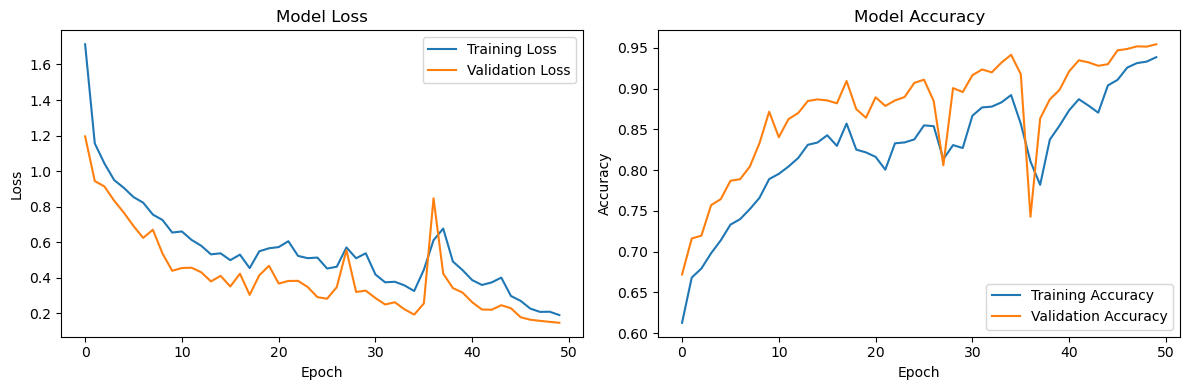

Creating test dataset...
Generating predictions...
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step
Predictions saved to 'variety_predictions.csv'
Detailed predictions saved to 'variety_predictions_detailed.csv'


In [15]:
# Plot Learning Curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# Generate Predictions for Test Set
def create_test_dataset(test_path):
    """Create dataset for test images"""
    test_files = []
    test_ids = []
    
    for img_name in os.listdir(test_path):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(test_path, img_name)
            test_files.append(img_path)
            test_ids.append(img_name)
    
    # Create dataset without labels
    dataset = tf.data.Dataset.from_tensor_slices(test_files)
    dataset = dataset.map(lambda x: parse_image(x, 0)[0], num_parallel_calls=tf.data.AUTOTUNE)  # Only images, no labels
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset, test_ids

# Create test dataset
print("Creating test dataset...")
test_pred_dataset, test_image_ids = create_test_dataset(TEST_IMG_PATH)

# Generate predictions
print("Generating predictions...")
predictions = vit_variety_classifier.predict(test_pred_dataset)
predicted_variety_indices = np.argmax(predictions, axis=1)
predicted_varieties = variety_encoder.inverse_transform(predicted_variety_indices)

# Create submission dataframe
submission_df = pd.DataFrame({
    'image_id': test_image_ids,
    'variety': predicted_varieties
})

# Save predictions
submission_df.to_csv('variety_predictions.csv', index=False)
print("Predictions saved to 'variety_predictions.csv'")

# Create a more detailed submission file
confidence_df = pd.DataFrame({
    'image_id': test_image_ids,
    'variety': predicted_varieties,
    'confidence': np.max(predictions, axis=1)
})

# Add top 3 predictions for each image
for i in range(3):
    top_n_indices = np.argsort(predictions, axis=1)[:, -(i+1)]
    confidence_df[f'variety_top_{i+1}'] = variety_encoder.inverse_transform(top_n_indices)
    confidence_df[f'confidence_top_{i+1}'] = np.sort(predictions, axis=1)[:, -(i+1)]

confidence_df.to_csv('variety_predictions_detailed.csv', index=False)
print("Detailed predictions saved to 'variety_predictions_detailed.csv'")

